# Machine Learning Engineer Nanodegree
## Capstone Project
## Project: The Search for New Earths

This project analyses the data observed by the NASA Kepler space telescope searching for exoplanets using the transit technique.  
planets themselves do not emit light, but the stars that they orbit do. If said star is watched over several months or years, there may be a regular 'dimming' of the flux (the light intensity). This is evidence that there may be an orbiting body around the star; such a star could be considered to be a 'candidate' system.
NASA itself utilises python to interpret the data and has created PyKE, a library for data reduction to help with extraction and preprocessing of the light curve images, however this project analyses only FLUX data, not pictures.
Some of the machine learning techniques already been used by developers are 1-D CNN, XGBoosting, PCA.

## Getting Started
importing dependencied and Loading the dataset

In [48]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd
from IPython.display import display # Allows the use of display() for DataFrames
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from time import time
import scipy
import matplotlib.patches as mpatches
from sklearn.metrics import fbeta_score, accuracy_score,make_scorer ,confusion_matrix, precision_score
from sklearn.decomposition import PCA, NMF
from sklearn.preprocessing import normalize
from pandas.tools.plotting import autocorrelation_plot
from sklearn import svm
from imblearn.under_sampling import TomekLinks
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import IsolationForest
from imblearn.metrics import classification_report_imbalanced, sensitivity_specificity_support
from sklearn.model_selection import GridSearchCV, ShuffleSplit
from sklearn.pipeline import Pipeline

from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB,MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.multiclass import OneVsRestClassifier

import helper as hp
# Pretty display for notebooks
%matplotlib inline
print "Libraries imported successfully"

Libraries imported successfully


In [3]:
# Load the kepler training dataset
try:
    data = pd.read_csv(os.path.join("project_dataset", 'exoTrain.csv'),index_col=0)
    print "kepler dataset has {} samples with {} features each.".format(*data.shape)
except:
    print "Dataset could not be loaded. Is the dataset missing?"

kepler dataset has 5087 samples with 3198 features each.


## Prepare data
the author of the database labelled with 1 no exoplanet system and 2 exoplanet system

In [4]:
#create label array and drop it from features
labels = data.LABEL
#labels = [1 if x == 2 else 0 for x in labels]
labels.replace(1,0, inplace=True)
labels.replace(2,1, inplace=True)
data.drop('LABEL',axis=1, inplace =True)

In [5]:
# Display a description of the dataset
display(data.describe())

,FLUX-1,FLUX-2,FLUX-3,FLUX-4,FLUX-5,FLUX-6,FLUX-7,FLUX-8,FLUX-9,FLUX-10,...,FLUX-3188,FLUX-3189,FLUX-3190,FLUX-3191,FLUX-3192,FLUX-3193,FLUX-3194,FLUX-3195,FLUX-3196,FLUX-3197
count,5.087000e+03,5.087000e+03,5.087000e+03,5.087000e+03,5.087000e+03,5.087000e+03,5.087000e+03,5.087000e+03,5.087000e+03,5.087000e+03,...,5.087000e+03,5.087000e+03,5.087000e+03,5.087000e+03,5.087000e+03,5.087000e+03,5087.000000,5087.000000,5087.000000,5087.000000
mean,1.445054e+02,1.285778e+02,1.471348e+02,1.561512e+02,1.561477e+02,1.469646e+02,1.168380e+02,1.144983e+02,1.228639e+02,1.410852e+02,...,3.485578e+02,4.956476e+02,6.711211e+02,7.468790e+02,6.937372e+02,6.553031e+02,-494.784966,-544.594264,-440.239100,-300.536399
std,2.150669e+04,2.179717e+04,2.191309e+04,2.223366e+04,2.308448e+04,2.410567e+04,2.414109e+04,2.290691e+04,2.102681e+04,1.942289e+04,...,2.864786e+04,3.551876e+04,4.349963e+04,4.981375e+04,5.087103e+04,5.339979e+04,17844.469520,17722.339334,16273.406292,14459.795577
min,-2.278563e+05,-3.154408e+05,-2.840018e+05,-2.340069e+05,-4.231956e+05,-5.975521e+05,-6.724046e+05,-5.790136e+05,-3.973882e+05,-2.223300e+05,...,-3.240480e+05,-3.045540e+05,-2.933140e+05,-2.838420e+05,-3.288214e+05,-5.028894e+05,-775322.000000,-732006.000000,-700992.000000,-643170.000000
25%,-4.234000e+01,-3.952000e+01,-3.850500e+01,-3.505000e+01,-3.195500e+01,-3.338000e+01,-2.813000e+01,-2.784000e+01,-2.683500e+01,-2.797500e+01,...,-1.760000e+01,-1.948500e+01,-1.757000e+01,-2.076000e+01,-2.226000e+01,-2.440500e+01,-26.760000,-24.065000,-21.135000,-19.820000
50%,-7.100000e-01,-8.900000e-01,-7.400000e-01,-4.000000e-01,-6.100000e-01,-1.030000e+00,-8.700000e-01,-6.600000e-01,-5.600000e-01,-9.600000e-01,...,2.600000e+00,2.680000e+00,3.050000e+00,3.590000e+00,3.230000e+00,3.500000e+00,-0.680000,0.360000,0.900000,1.430000
75%,4.825500e+01,4.428500e+01,4.232500e+01,3.976500e+01,3.975000e+01,3.514000e+01,3.406000e+01,3.170000e+01,3.045500e+01,2.874500e+01,...,2.211000e+01,2.235000e+01,2.639500e+01,2.909000e+01,2.780000e+01,3.085500e+01,18.175000,18.770000,19.465000,20.280000
max,1.439240e+06,1.453319e+06,1.468429e+06,1.495750e+06,1.510937e+06,1.508152e+06,1.465743e+06,1.416827e+06,1.342888e+06,1.263870e+06,...,1.779338e+06,2.379227e+06,2.992070e+06,3.434973e+06,3.481220e+06,3.616292e+06,288607.500000,215972.000000,207590.000000,211302.000000


#### normalisation
i will normalise the features by sample to better visualise autocorrelation

In [6]:
log_data = pd.DataFrame(normalize(data), columns = data.keys(), index = data.index)
display(log_data[labels ==1].head())

,FLUX-1,FLUX-2,FLUX-3,FLUX-4,FLUX-5,FLUX-6,FLUX-7,FLUX-8,FLUX-9,FLUX-10,...,FLUX-3188,FLUX-3189,FLUX-3190,FLUX-3191,FLUX-3192,FLUX-3193,FLUX-3194,FLUX-3195,FLUX-3196,FLUX-3197
1,0.010309,0.009206,0.002208,-0.002964,-0.004345,-0.013699,-0.014849,-0.010575,-0.008775,-0.017594,...,-0.008575,-0.011220,-0.011220,0.002760,0.005335,0.010165,0.004319,0.006747,0.000558,-0.004343
2,-0.011373,-0.009896,-0.017124,-0.011727,-0.023200,-0.021299,-0.025318,-0.024961,-0.024563,-0.021465,...,-0.000959,-0.009422,-0.009422,-0.007281,-0.001422,0.000222,-0.003423,0.001890,0.004680,0.005830
3,0.033411,0.033617,0.032225,0.031170,0.028632,0.029231,0.029137,0.030510,0.027384,0.030384,...,-0.004497,0.000835,0.000835,-0.001875,-0.001310,0.000317,-0.000740,-0.001813,-0.004392,-0.006064
4,0.055889,0.059461,0.051752,0.051029,0.054386,0.053523,0.055172,0.053285,0.053475,0.055343,...,0.000977,-0.000638,-0.000638,0.005144,0.003428,-0.002169,-0.001501,-0.002963,-0.002970,0.002393
5,-0.048077,-0.048311,-0.048587,-0.047551,-0.045921,-0.044919,-0.043350,-0.044408,-0.042969,-0.042157,...,-0.025809,-0.017441,-0.017441,-0.015512,-0.019269,-0.019042,-0.017356,-0.016702,-0.017881,-0.022169


### visualization of luminosity on time series
#### note
some system have strong drops in luminescence, this systems must have a big or close planet orbiting it, this makes this type of system easier to diferenciate from the non exo-systems, i will analyse more in details the ones where there is less clarity.

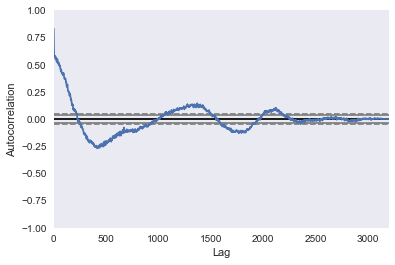

In [17]:
autocorrelation_plot(data.loc[37])

In [ ]:
fig = plt.figure(figsize=(30,40))
x = np.array(range(3197))
for i in range(37):
    ax = fig.add_subplot(8,5,i+1)
    ax.scatter(x,data.iloc[i,:])

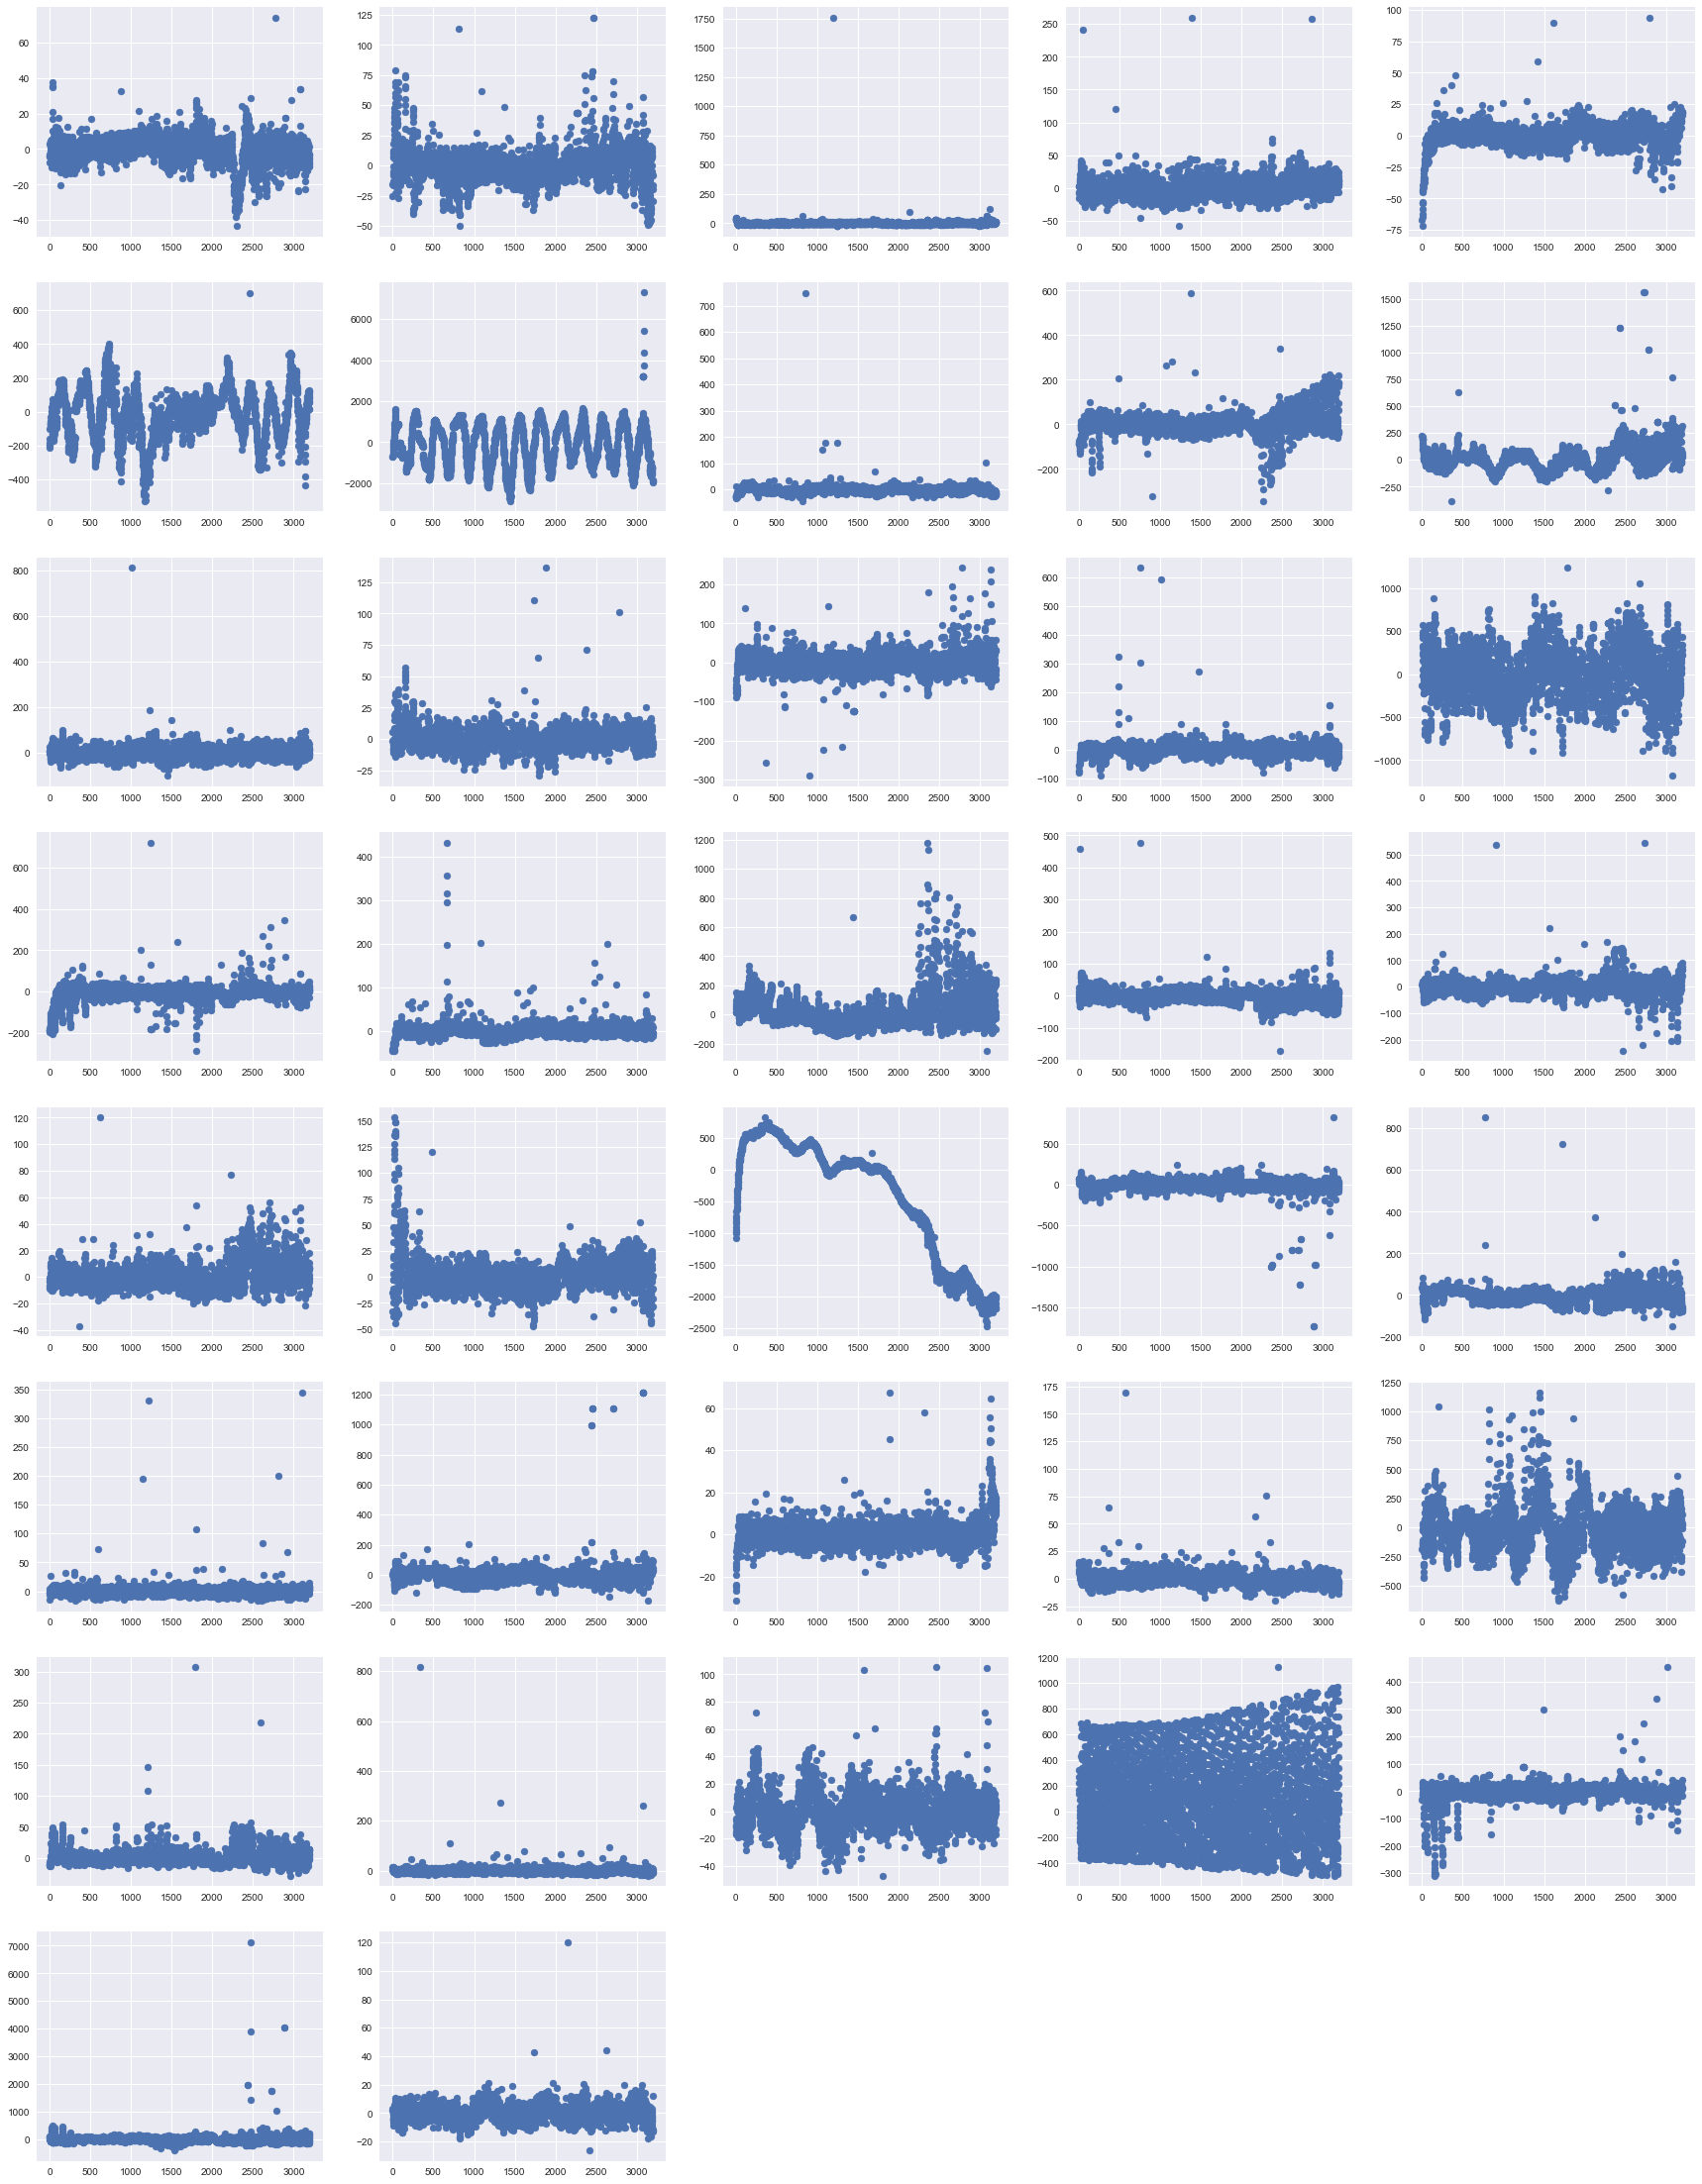

In [23]:
cnt = hp.find_outliers(log_data)
outliers = list(cnt.most_common(37))
fig = plt.figure(figsize=(30,40))
x = np.array(range(3197))
for i in range(37):
    outliers[i] = outliers[i][0]
    ax = fig.add_subplot(8,5,i+1)
    ax.scatter(x,data.iloc[outliers[i],:])

In [ ]:
#special outlier
fig , ax = plt.subplots(figsize=(7,7))
ax.scatter(x,data.iloc[outliers[22],:])

In [36]:
#remove the 1% outliers
OnePer = int(len(data['FLUX-1'])/100)
print "removed 1% of the outliers which is: {} ".format(OnePer)
outliers = list(cnt.most_common(OnePer))
for i in range(OnePer):
    outliers[i] = outliers[i][0]
good_data = data.drop(data.index[outliers]).reset_index(drop = True)
good_lables = labels.drop(labels.index[outliers]).reset_index(drop = True)

removed 1% of the outliers which is: 50 


## class imbalance correction
at this point we are ready to apply correction for class imbalance

using Tomek link for undersampling as final solution

In [18]:
TL = TomekLinks(n_jobs =-1,random_state=42)
under_data, under_labels = TL.fit_sample(data,labels)

In [42]:
Ifo = IsolationForest(n_jobs = -1,random_state =42)
ifo = Ifo.fit(good_data[good_lables == 0])
y_pred = ifo.predict(good_data)
y_pred = [0 if i == -1 else 1 for i in y_pred]

In [43]:
st, sp, su = sensitivity_specificity_support(good_lables,y_pred)
print 'sensitivity: {}, specitivity: {}, support : {}'.format(st, sp, su)
print classification_report_imbalanced(good_lables, y_pred)

sensitivity: [ 0.8928  0.    ], specitivity: [ 0.      0.8928], support : [5000   37]
                   pre       rec       spe        f1       geo       iba       sup

          0       0.99      0.89      0.00      0.94      0.00      0.00      5000
          1       0.00      0.00      0.89      0.00      0.00      0.00        37

avg / total       0.98      0.89      0.01      0.93      0.00      0.00      5037



## Pipeline for classification

In [40]:
def mod_clas(y_pred):
    y_pred = [0 if i == -1 else 1 for i in y_pred]
    return y_pred

In [ ]:
#hp.vs_class_imbalance(log_data, labels,X_resampled, y_resampled)

In [55]:
def fit_model(X, y):
    pca = PCA(random_state = 42)
    score = make_scorer(precision_score)
    #svc = svm.OneClassSVM(nu=0.5, kernel="rbf", gamma=0.0003)
    gbc = GradientBoostingClassifier(n_estimators = 100, max_depth= 7,min_impurity_split= 100000.0,random_state = 42)
    Pipe = Pipeline([('pca',PCA()),('clas', gbc)])

    # Create cross-validation sets from the training data
    cv_sets = ShuffleSplit(X.shape[0],test_size = 0.20, random_state = 42)

    #params dictionary for grid search
    ##test:
    ##learning_rate: (0.1,0.08,0.01,0.5)n_estimators:(50,100,180,200,250)max_depth(3,4,5,6,7,8,10)
    params = {'pca__n_components':(5,10,50,100),
                        'pca__whiten': (False,True)
                   #     'svm__nu':(0.1,0.5,0.6),
                      #  'svm__gamma': (0.0001,0.0003,0.0005)
             }

    #scoring function using 'make_scorer' 
    scoring_fnc = make_scorer(precision_score)

    #Create the grid search object
    grid = GridSearchCV(Pipe,params,scoring = scoring_fnc,cv = cv_sets)

    # Fit the grid search object to the data to compute the optimal model
    grid = grid.fit(X, y)

    # Return the optimal model after fitting the data
    return grid.best_estimator_

In [ ]:
model = fit_model(good_data,good_lables)

C:\Users\andre\Anaconda2\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [ ]:
#testing performance against benchmark
clf.fit(X_trainPCA[labels == 0])
y_pred = clf.predict(X_trainPCA)

y_pred = [0 if i == -1 else 1 for i in y_pred]

st, sp, su = sensitivity_specificity_support(labels,y_pred)
print 'sensitivity: {}, specitivity: {}, support : {}'.format(st, sp, su)
Ifo = IsolationForest(n_jobs = -1,random_state =42).fit(X_trainPCA[labels == 0])

y_pred = Ifo.predict(X_trainPCA)

y_pred = [0 if i == -1 else 1 for i in y_pred]

st, sp, su = sensitivity_specificity_support(labels,y_pred)
print 'sensitivity: {}, specitivity: {}, support : {}'.format(st, sp, su)

In [ ]:
#train test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled,stratify =y_resampled,  test_size=0.4, random_state=42)
#save data
pickle.dump((X_train, y_train), open('SmoteTomek-Train.p', 'wb'))
pickle.dump((X_test, y_test), open('SmoteTomek-Validation.p', 'wb'))

## Checkpoint
resampled data saved

## TODO:
NMF, SVD, LatentDirichletAllocation.
one VS rest SVM classifier
mix-max scaler + log
## Feature Transformation
### application of PCA looking for best number of features
explained variance on training set
* Dimension 1     0.4829
* Dimension 2     0.8346
* Dimension 3     0.8847
* Dimension 4     0.9226
* Dimension 5     0.9438
* Dimension 6     0.9620
* Dimension 7     0.9772
* Dimension 8     0.9830
* Dimension 9     0.9855
* Dimension 10    0.9874

In [ ]:
# Load the Preprocessed data
X_train, y_train = pickle.load(open('SmoteTomek-Train.p', mode='rb'))
X_val, y_val = pickle.load(open('SmoteTomek-Validation.p', mode='rb'))

### Visualize Data
since with 2 dimention we can describe 83.4% of the data we are able to plot a scatted of it

In [ ]:
def vs_frontiers(good_data,good_lables):
    print(__doc__)

    import numpy as np
    import matplotlib.pyplot as plt
    import matplotlib.font_manager
    from sklearn import svm
    pca = PCA(n_components=2, random_state = 42)
    #X_train, X_test, y_train, y_test = train_test_split(good_data[good_lables ==0].sample(10000), good_lables[good_lables ==0].samlep(10000), test_size=0.4, random_state=42)
    #xx, yy = np.meshgrid(good_data,500,sparse=True)
    xx, yy = np.meshgrid(np.linspace(-10000,10000, 500), np.linspace(-10000,10000, 500))

    X_train = pca.fit_transform(good_data[good_lables == 0].sample(11000))
    X_test = pca.transform(good_data[good_lables == 0].sample(10634))
    X_outliers = pca.transform(good_data[good_lables == 1])
    #X_TrainOUTliers = pca.transform(outliers)

    # fit the model
    clf = IsolationForest(n_jobs = -1,random_state =42).fit(X_train)
    #predict
    y_pred_train = clf.predict(X_train)
    y_pred_test = clf.predict(X_test)
    y_pred_outliers =clf.predict(X_outliers)
    n_error_train = y_pred_train[y_pred_train == -1].size
    n_error_test = y_pred_test[y_pred_test == -1].size
    n_error_outliers = y_pred_outliers[y_pred_outliers == 1].size

    # plot the line, the points, and the nearest vectors to the plane
    Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.figure(figsize=(20,20))
    plt.title("Novelty Detection")
    plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), 10000, 7), cmap=plt.cm.PuBu)
    a = plt.contour(xx, yy, Z, levels=[0], linewidths=2, colors='darkred')
    plt.contourf(xx, yy, Z, levels=[0, Z.max()], colors='palevioletred')
    s = 30
    b1 = plt.scatter(X_train[:, 0], X_train[:, 1], c='white', s=s)
    b2 = plt.scatter(X_test[:, 0], X_test[:, 1], c='blueviolet', s=s)
    c = plt.scatter(X_outliers[:, 0], X_outliers[:, 1], c='gold', s=s)
    #d = plt.scatter(X_TrainOUTliers[:, 0], X_TrainOUTliers[:, 1], c='red', s=s)
    plt.axis('tight')
    plt.xlim((-5, 20))
    plt.ylim((-10, 10))
    plt.legend([a.collections[0], b1, b2, c],
               ["learned frontier", "training observations",
                "new regular observations", "new abnormal observations"],
               loc="upper left",
               prop=matplotlib.font_manager.FontProperties(size=11))
    plt.xlabel(
        "error train: %d/40000 ; errors novel regular: %d/10634 ; "
        "errors novel abnormal: %d/10634"
        % (n_error_train, n_error_test, n_error_outliers))
    plt.show()
vs_frontiers(good_data,good_labels)

In [ ]:
from sklearn.naive_bayes import GaussianNB,MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier

#Initialize the three models
clf_A = SVC()
clf_B = MultinomialNB()
clf_C = GradientBoostingClassifier(n_estimators = 100, max_depth= 7,min_impurity_split= 100000.0,random_state = 42)
tot_training = X_trainPCA.shape[0]

#Calculate the number of samples for 1%, 10%,100% of the training data
samples_1 =   int(tot_training * 0.2)
samples_10 =  int(tot_training * 0.4)
samples_100 = int(tot_training * 1)

# Collect results on the learners
results = {}
for clf in [clf_A, clf_B, clf_C]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        results[clf_name][i] = \
        train_predict(clf, samples, X_trainPCA, y_train, X_testPCA, y_val)

# Run metrics visualization for the three supervised learning models chosen
evaluate(results, 0.3, 0.3)

### Model Selection and optimisation


### Observation
Run the code below to see how the log-transformed sample data has changed after having a PCA transformation applied to it using only two dimensions. Observe how the values for the first two dimensions remains unchanged when compared to a PCA transformation in six dimensions.

In [ ]:
#from sklearn.metrics import classification_report
y_pred = clf_B.predict(X_testPCA)
print classification_report_imbalanced(y_val, y_pred)

In [ ]:
def performance_metric(y_true, y_predict):
    """ Calculates and returns the performance score between 
        true and predicted values based on the metric chosen. """
    # TODO: Calculate the performance score between 'y_true' and 'y_predict'
    score = fbeta_score(y_true, y_predict,beta =1.5) 
    # Return the score
    return score

In [ ]:
# Fit the training data to the model using grid search
#use all training data
X_train_all = np.vstack([X_train,X_val])
y_train_all = np.concatenate((y_train,y_val),axis=0)
X_trainPCA = pca.transform(X_train_all)
#clf = fit_model(X_trainPCA, y_train_all)
clf_B = clf_B.fit(X_trainPCA,y_train_all)
print 'operation completed'

In [ ]:
display(clf.get_params())
y_pred = clf.predict(X_testPCA)
print classification_report_imbalanced(y_test, y_pred)

## loading testing data
now load the test data and test on the classifier.

In [ ]:
# Load the kepler dataset
Testdata = pd.read_csv(os.path.join("project_dataset", 'exoTest.csv'),index_col=0)
#    print "kepler dataset has {} samples with {} features each.".format(*data.shape)
#except:
#    print "Dataset could not be loaded. Is the dataset missing?"

In [ ]:
#create label array and drop it from features
testlabels = Testdata.LABEL
#labels = [1 if x == 2 else 0 for x in labels]
testlabels.replace(1,0, inplace=True)
testlabels.replace(2,1, inplace=True)
Testdata.drop('LABEL',axis=1, inplace =True)

## evaluation of the result

In [ ]:
X_test = pca.transform(Testdata)
#y_pred = clf.predict(X_test)
y_pred = clf.predict(X_test)

y_pred = [0 if i == -1 else 1 for i in y_pred]

st, sp, su = sensitivity_specificity_support(testlabels,y_pred)
print 'sensitivity: {}, specitivity: {}, support : {}'.format(st, sp, su)
print classification_report_imbalanced(testlabels, y_pred)
print confusion_matrix(testlabels, y_pred, labels = [0,1])